<a href="https://colab.research.google.com/github/priya456-hash/Thesis/blob/main/BONE_SEGMENT_ANALYSIS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing required libraries

import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile 
import heapq
import matplotlib.image as mpimg
import tensorflow as tf 
from scipy.stats import pearsonr
from tensorflow.keras import layers 
from tensorflow.keras import models 
from tensorflow.keras import Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)



LOAD TENSORFLOW

In [ ]:
# Loading tensorflow 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input

CONFIGS

In [ ]:
CFG = dict(
        batch_size        =  16,     # 8; 16; 32; 64; bigger batch size leads to memory allocation issues. 
        epochs            =  100,   # 5; 10; 20;
        verbose           =   1,    # 0; 1
        workers           =   4,    # 1; 2; 3

        optimizer         = 'adam', # 'SGD', 'RMSprop'

        RANDOM_STATE      =  123,   
    
        # Path to save a model
        path_model        = '../working/',

        # Images sizes
        img_size          = 224, 
        img_height        = 224, 
        img_width         = 224, 

        # Images augs
        ROTATION          = 180.0,
        ZOOM              =  10.0,
        ZOOM_RANGE        =  [0.9,1.1],
        HZOOM             =  10.0,
        WZOOM             =  10.0,
        HSHIFT            =  10.0,
        WSHIFT            =  10.0,
        SHEAR             =   5.0,
        HFLIP             = True,
        VFLIP             = True,

        # Postprocessing
        label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;    
)



In [ ]:
# Unzip all files to same directory of zip file
zip_file = '/content/Bone_parts.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Create a test, train and validation directories
dir = '/content/Bone_parts'
train_dir = os.path.join(dir, 'train')
validation_dir = os.path.join(dir, 'validation')
test_dir = os.path.join(dir, 'test')

# Biomaterial Directories
train_Biomaterial_dir = os.path.join(train_dir, 'biomaterial')
test_Biomaterial_dir = os.path.join(test_dir, 'biomaterial')

# bone_marrow Directories
train_bone_marrow_dir = os.path.join(train_dir, 'bone_marrow')
test_bone_marrow_dir = os.path.join(test_dir, 'bone_marrow')

#bone_with_osteocytes directories
train_bone_with_osteocytes_dir = os.path.join(train_dir, 'bone_with_osteocytes')
test_bone_with_osteocytes_dir = os.path.join(test_dir, 'bone_with_osteocytes')

#bone_without_osteocytes
train_bone_without_osteocytes_dir = os.path.join(train_dir, 'bone_without_osteocytes')
test_bone_without_osteocytes_dir = os.path.join(test_dir, 'bone_without_osteocytes')


# tissue_fibrous
train_tissue_fibrous_dir = os.path.join(train_dir, 'tissue_fibrous')
test_tissue_fibrous_dir = os.path.join(test_dir, 'tissue_fibrous')

print(train_tissue_fibrous_dir)


/content/Bone_parts/train/tissue_fibrous


In [ ]:
print('/content')

/content


In [ ]:
#image size 
print(train_dir)
img = Image.open(train_dir+'/tissue_fibrous/4-5 1.tif')
print(img.size) 

/content/Bone_parts/train
(224, 224)


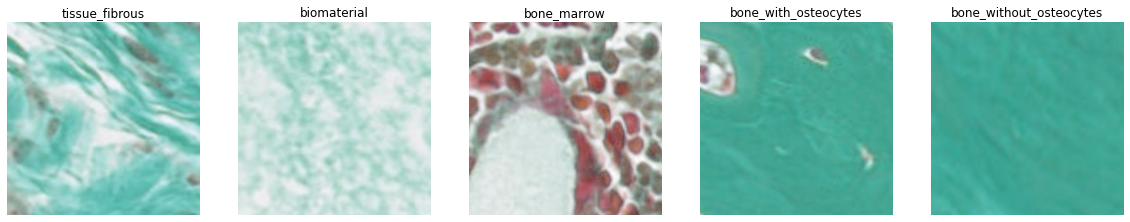

In [ ]:
# Plot a sample image

#create list for all images
images = []
names = []

#Get first image of tissue_fibrous
train_tissue_fibrous_filenames = os.listdir(train_tissue_fibrous_dir)

#Plot the first image
images.append(mpimg.imread(train_tissue_fibrous_dir + "/" + train_tissue_fibrous_filenames[0]))
names.append("tissue_fibrous")

#Get first image of biomaterial
train_Biomaterial_filenames = os.listdir(train_Biomaterial_dir)

#Plot the first image
images.append(mpimg.imread(train_Biomaterial_dir + "/" + train_Biomaterial_filenames[0]))
names.append("biomaterial")

#Get first image of bone marrow
train_bone_marrow_filenames = os.listdir(train_bone_marrow_dir)

#Plot the first image
images.append(mpimg.imread(train_bone_marrow_dir + "/" + train_bone_marrow_filenames[0]))
names.append("bone_marrow")

#Get first image of bone with osteocytes 
train_bone_with_osteocytes_filenames = os.listdir(train_bone_with_osteocytes_dir)

#Plot the first image
images.append(mpimg.imread(train_bone_with_osteocytes_dir + "/" + train_bone_with_osteocytes_filenames[0]))
names.append("bone_with_osteocytes")

#Get first image of tissue_fibrous
train_bone_without_osteocytes_filenames = os.listdir(train_bone_without_osteocytes_dir)
names.append("bone_without_osteocytes")

#Plot the first image
images.append(mpimg.imread(train_bone_without_osteocytes_dir + "/" + train_bone_without_osteocytes_filenames[0]))

nrows = 1
ncols = 5
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
for i in range(5):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(images[i])
  plt.title(names[i])
plt.show()

 **Keras image data processing**

In [ ]:
# https://keras.io/api/preprocessing/image/

# Data Augmentation 

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.4,
    rotation_range            = CFG['ROTATION'],
    zoom_range                = CFG['ZOOM_RANGE'],
    horizontal_flip           = CFG['HFLIP'],
    vertical_flip             = CFG['VFLIP'],
    height_shift_range        = CFG['HSHIFT'],
    width_shift_range         = CFG['WSHIFT'],
    shear_range               = CFG['SHEAR'],
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',
                          
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.4)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test


# Train data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    subset='training',                  # to read train/valid from same directory 
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                    batch_size = CFG['batch_size'],
                                                    class_mode='categorical'
                                                    )

# Validation data
valid_generator = valid_generator.flow_from_directory(train_dir,
                                                     subset='validation',               # to read train/valid from same directory 
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = CFG['batch_size'],
                                                     class_mode='categorical'
                                               
                                                     ) 
# Test data
test_generator  = test_generator.flow_from_directory(test_dir,
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = 1,                    # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode='categorical',shuffle=False    
)

Found 150 images belonging to 5 classes.
Found 96 images belonging to 5 classes.
Found 209 images belonging to 5 classes.


Use of Class weights 

In [ ]:
# Class weights for assigning different weights to the classes. 
# calculate the class weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes), 
                                                  train_generator.classes) 

unique_class_weights = np.unique(train_generator.classes)
class_weights_dict   = { unique_class_weights[i]: w for i,w in enumerate(class_weights) }

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator.classes))
print(train_generator.classes)
print(unique_class_weights)
print(Counter(train_generator.classes).keys())   # equals to list(set(x))
print(Counter(train_generator.classes).values()) # counts the elements' frequency


CLASS WEIGHTS: [0.9375     1.2        1.03448276 0.9375     0.9375    ]

[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]
[0 1 2 3 4]
dict_keys([0, 1, 2, 3, 4])
dict_values([32, 25, 29, 32, 32])


**Model**



Build model with VGG16

Adding two layers : - Global Average Pooling layer and Dense layer 
Activation function: - Softmax 


In [ ]:
model_VGG16 = tf.keras.Sequential([
     tf.keras.applications.VGG16(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    
    GlobalAveragePooling2D(),
    
    #Dense(1024, activation = 'relu'), 
    #Dropout(0.5), 
    #BatchNormalization(),
    
    #Dense(256, activation='relu'), 
    #Dropout(0.3), 
    #BatchNormalization(),
    
    #Dense(64, activation='relu'), 
    #Dropout(0.2), 
    #BatchNormalization(),
    
    Dense(5, activation='softmax') 
    
])
    
model_VGG16.compile(
    optimizer = CFG['optimizer'],
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CFG['label_smooth_fac']),
    #loss = 'binary_crossentropy',
    metrics=['accuracy']
)

**Visualize model with VGG16**

In [ ]:
model_VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We reduce significantly number of trainable parameters by freezing certain layers, excluding from training, i.e. their weights will never be updated

# freeze the first 1 layer

model_VGG16.layers[0].trainable = False
#for layer in model_VGG16.layers[:1]:
#    layer.trainable = False
model_VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


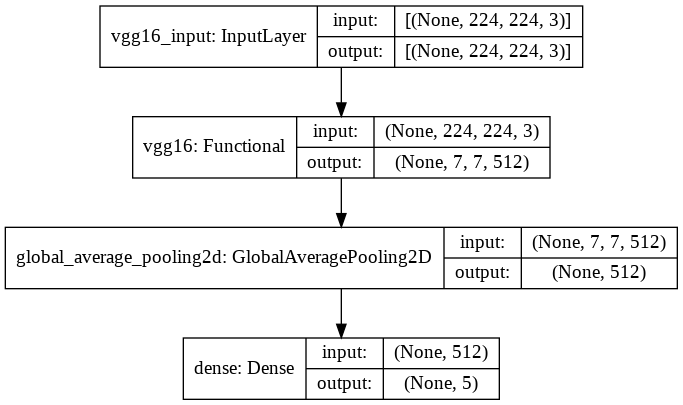

In [ ]:
# Plot model scheme with TF/Keras plot_model function
plot_model(model_VGG16, to_file='model_plot.png', show_shapes=True, show_layer_names=True) # select any number of samples 

In [ ]:
len(model_VGG16.layers) 

3

**Fit model**

In [ ]:
#REFERENCES: tf.function-decorated function tried to create variables on non-first call'. 
tf.config.run_functions_eagerly(True) # otherwise error, useful for debugging.

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
#Callback to save the Keras model or model weights at some frequency
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(#filepath=path_model,
                                   #filepath=CFG['path_model']+'VGG16.hdf5'
                                   filepath = CFG['path_model']+'VGG16-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history = model_VGG16.fit(train_generator, 
                             epochs=CFG['epochs'], 
                             workers=CFG['workers'],
                             steps_per_epoch = train_generator.n // 2, 
                             validation_data=valid_generator, 
                             shuffle=False,
                             validation_steps=valid_generator.n // 2, 
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            )

Epoch 1/100
75/75 [==============================] - 54s 714ms/step - loss: 0.0269 - accuracy: 0.9832 - val_loss: 0.2288 - val_accuracy: 0.8958

Epoch 00001: val_loss improved from inf to 0.22881, saving model to ../working/VGG16-01-0.23.hdf5
Epoch 2/100
75/75 [==============================] - 54s 715ms/step - loss: 0.0396 - accuracy: 0.9726 - val_loss: 0.2276 - val_accuracy: 0.8542

Epoch 00002: val_loss improved from 0.22881 to 0.22765, saving model to ../working/VGG16-02-0.23.hdf5
Epoch 3/100
75/75 [==============================] - 54s 715ms/step - loss: 0.0214 - accuracy: 0.9841 - val_loss: 0.1226 - val_accuracy: 0.8958

Epoch 00003: val_loss improved from 0.22765 to 0.12261, saving model to ../working/VGG16-03-0.12.hdf5
Epoch 4/100
75/75 [==============================] - 54s 716ms/step - loss: 0.0191 - accuracy: 0.9823 - val_loss: 0.1804 - val_accuracy: 0.8750

Epoch 00004: val_loss did not improve from 0.12261
Epoch 5/100
75/75 [==============================] - 54s 712ms/step

**Visualize performance**

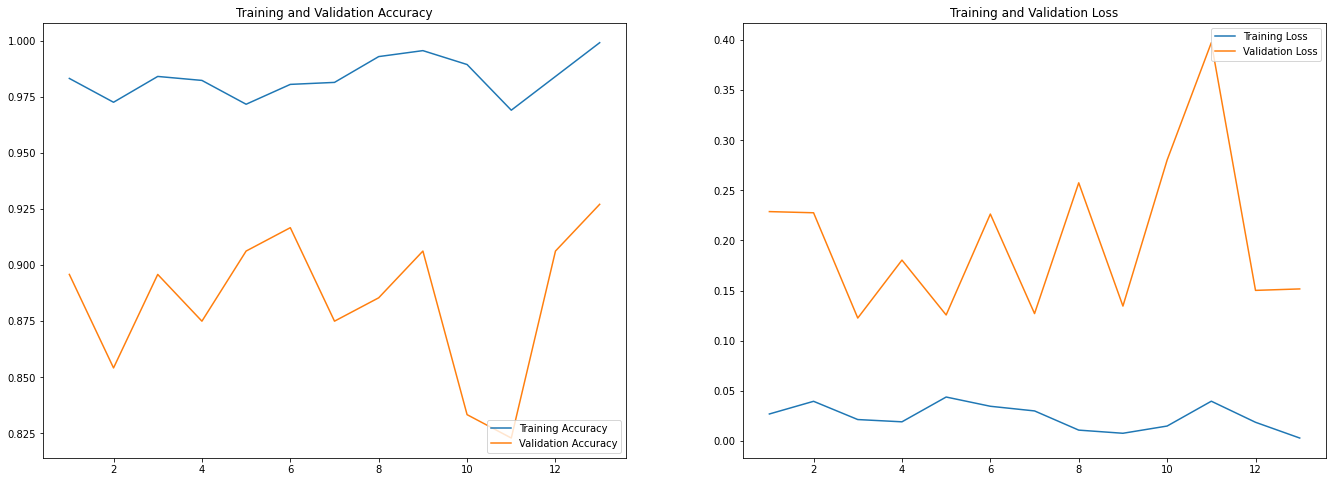

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluate on test data

In [ ]:
print("Evaluate on test data")
results = model_VGG16.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
209/209 [==============================] - 9s 41ms/step - loss: 0.0781 - accuracy: 0.9665
test loss, test acc: [0.07809068262577057, 0.9665071964263916]


In [ ]:
print("Evaluate on test data")
results = model_VGG16.evaluate(test_generator)
print("test loss, test acc:", results)



Evaluate on test data
209/209 [==============================] - 9s 41ms/step - loss: 0.0781 - accuracy: 0.9665
test loss, test acc: [0.07809068262577057, 0.9665071964263916]


In [ ]:
# Saving the model for future use
model_VGG16.save('custom_model.h5py')

INFO:tensorflow:Assets written to: custom_model.h5py/assets


**PREDICTION**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img

def predict_image(filename):
    img = load_img(filename, target_size=(224, 224))
    image = keras.preprocessing.image.img_to_array(img)
    image = image / 255.0
    image = image.reshape(1,224,224,3)
    model = tf.keras.models.load_model('custom_model.h5py')
    prediction = model.predict(image)
    print(prediction)
    plt.imshow(img)

    biomaterial_stat = prediction[0][0] * 100
    bonemarrow_stat = prediction[0][1] * 100
    bone_with_osteocytes_stat = prediction[0][2] * 100
    bone_without_osteocytes_stat = prediction[0][3] * 100
    tissue_fibrous_stat = prediction[0][4] * 100
    print("This image is %.2f percent %s"% (biomaterial_stat, "biomaterial\n"), 
          "This image is %.2f percent %s"% (bonemarrow_stat, "bone marrow\n"),
          "This image is %.2f percent %s"% (bone_with_osteocytes_stat, "bone_with_osteocytes\n"),
          "This image is %.2f percent %s"% (bone_without_osteocytes_stat, "bone_without_osteocytes\n"), 
          "This image is %.2f percent %s"% (tissue_fibrous_stat, "tissue_fibrous"))
   


[[9.9999642e-01 1.4434526e-06 2.4245115e-11 3.0772556e-09 2.1878891e-06]]
This image is 100.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


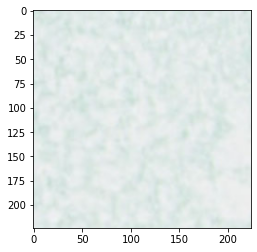

In [ ]:
predict_image("/content/Bone_parts/test/biomaterial/1-8 1.tif")

[[9.9999583e-01 1.4868535e-06 3.1158888e-11 4.1900772e-09 2.7120941e-06]]
This image is 100.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


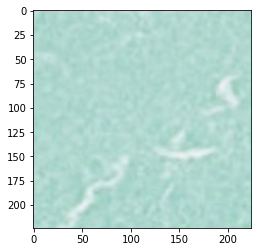

In [ ]:
predict_image("/content/Bone_parts/test/biomaterial/2-2 3.tif")

[[9.9999642e-01 1.4589807e-06 2.2857603e-11 2.8622680e-09 2.1181897e-06]]
This image is 100.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


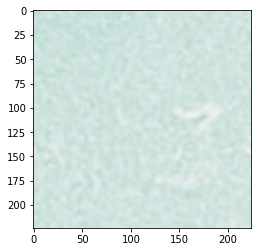

In [ ]:
predict_image("/content/Bone_parts/test/biomaterial/2fromrightdown2-1.tif")

[[9.9999666e-01 1.3717603e-06 1.7246623e-11 2.2053361e-09 1.9335071e-06]]
This image is 100.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


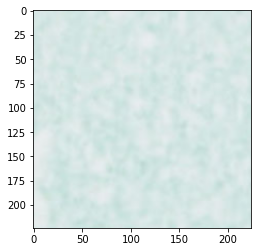

In [ ]:
predict_image("/content/Bone_parts/test/biomaterial/ML-1.tif")

[[1.07525274e-07 9.72377360e-01 8.15065260e-09 2.69263097e-07
  2.76222881e-02]]
This image is 0.00 percent biomaterial
 This image is 97.24 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 2.76 percent tissue_fibrous


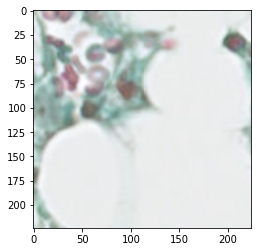

In [ ]:
predict_image("/content/Bone_parts/test/bone_marrow/big-1.tif")

[[1.0125481e-12 9.9998295e-01 2.2552307e-10 2.2387198e-08 1.7053233e-05]]
This image is 0.00 percent biomaterial
 This image is 100.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


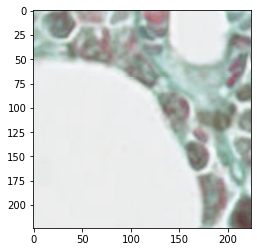

In [ ]:
predict_image("/content/Bone_parts/test/bone_marrow/big-2.tif")

[[2.9324706e-27 1.0000000e+00 7.6751808e-20 3.0665319e-17 2.2824178e-19]]
This image is 0.00 percent biomaterial
 This image is 100.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


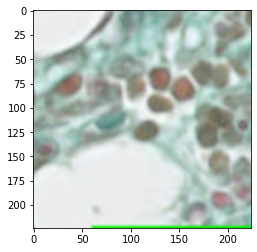

In [ ]:
predict_image("/content/Bone_parts/test/bone_marrow/big-3.tif")

[[2.3110223e-27 4.4305663e-11 3.3401819e-13 3.3819321e-18 1.0000000e+00]]
This image is 0.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 100.00 percent tissue_fibrous


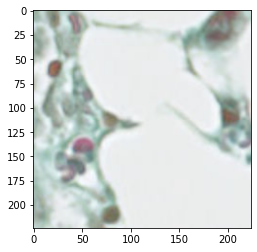

In [ ]:
predict_image("/content/Bone_parts/test/bone_marrow/big-4.tif")

[[3.8903942e-17 1.9494098e-04 9.4642832e-07 3.7687048e-11 9.9980408e-01]]
This image is 0.00 percent biomaterial
 This image is 0.02 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 99.98 percent tissue_fibrous


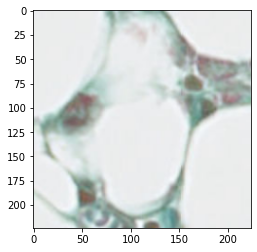

In [ ]:
predict_image("/content/Bone_parts/test/bone_marrow/big-5.tif")

[[8.189121e-08 8.914468e-05 2.037622e-07 6.621581e-05 9.998443e-01]]
This image is 0.00 percent biomaterial
 This image is 0.01 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.01 percent bone_without_osteocytes
 This image is 99.98 percent tissue_fibrous


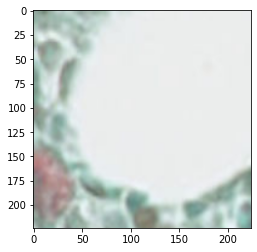

In [ ]:
predict_image("/content/Bone_parts/test/bone_marrow/middle-1.tif")

[[6.8827767e-18 9.8625553e-01 9.7501971e-09 1.8975655e-07 1.3744323e-02]]
This image is 0.00 percent biomaterial
 This image is 98.63 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 1.37 percent tissue_fibrous


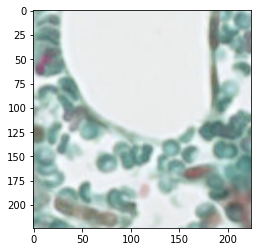

In [ ]:
predict_image("/content/Bone_parts/test/bone_marrow/middle-2.tif")

[[8.8693085e-18 9.8881757e-01 2.3488889e-09 3.9852621e-11 1.1182449e-02]]
This image is 0.00 percent biomaterial
 This image is 98.88 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 1.12 percent tissue_fibrous


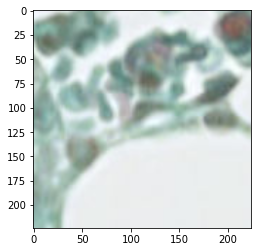

In [ ]:
predict_image("/content/Bone_parts/test/bone_marrow/small-1.tif")

[[3.8434732e-17 7.8821245e-07 2.0990912e-10 1.5539825e-09 9.9999917e-01]]
This image is 0.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 100.00 percent tissue_fibrous


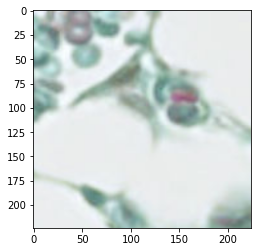

In [ ]:
predict_image("/content/Bone_parts/test/bone_marrow/small-2.tif")

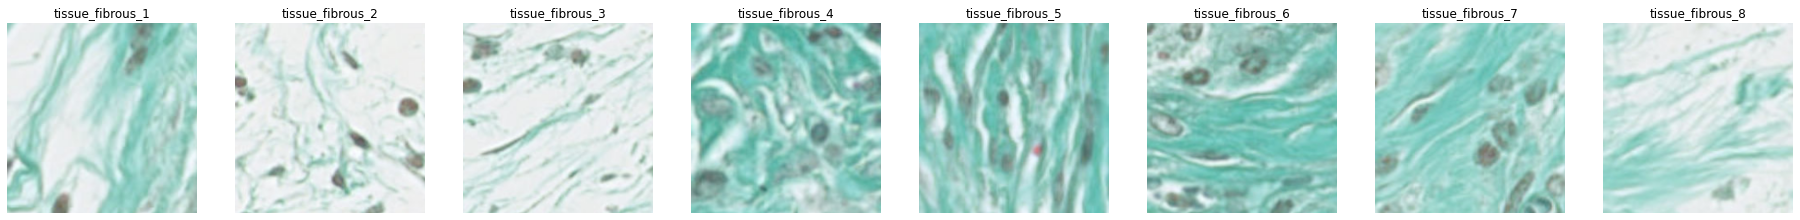

In [ ]:
#To compare fibrous tissue and bone marrow as they are being predicted similar in few cases. 

images = []
names = []

#Get first image of tissue_fibrous
test_tissue_fibrous_filenames = os.listdir(test_tissue_fibrous_dir)

#Plot the first image
images.append(mpimg.imread(test_tissue_fibrous_dir + "/" + test_tissue_fibrous_filenames[0]))
names.append("tissue_fibrous_1")

#Get second image of fibrous tissue
test_tissue_fibrous_filenames = os.listdir(test_tissue_fibrous_dir)

#Plot the first image
images.append(mpimg.imread(test_tissue_fibrous_dir + "/" + test_tissue_fibrous_filenames[1]))
names.append("tissue_fibrous_2")

#Get first image of bone marrow
test_tissue_fibrous_filenames = os.listdir(test_tissue_fibrous_dir)

#Plot the first image
images.append(mpimg.imread(test_tissue_fibrous_dir + "/" + test_tissue_fibrous_filenames[2]))
names.append("tissue_fibrous_3")

#Get first image of bone with osteocytes 
test_tissue_fibrous_filenames = os.listdir(test_tissue_fibrous_dir)

#Plot the first image
images.append(mpimg.imread(test_tissue_fibrous_dir + "/" + test_tissue_fibrous_filenames[3]))
names.append("tissue_fibrous_4")

#Get first image of tissue_fibrous
test_tissue_fibrous_filenames = os.listdir(test_tissue_fibrous_dir)
names.append("tissue_fibrous_5")

#Plot the first image
images.append(mpimg.imread(test_tissue_fibrous_dir + "/" + test_tissue_fibrous_filenames[4]))


#Get first image of tissue_fibrous
test_tissue_fibrous_filenames = os.listdir(test_tissue_fibrous_dir)
names.append("tissue_fibrous_6")

#Plot the first image
images.append(mpimg.imread(test_tissue_fibrous_dir + "/" + test_tissue_fibrous_filenames[5]))

#Get first image of tissue_fibrous
test_tissue_fibrous_filenames = os.listdir(test_tissue_fibrous_dir)
names.append("tissue_fibrous_7")

#Plot the first image
images.append(mpimg.imread(test_tissue_fibrous_dir + "/" + test_tissue_fibrous_filenames[6]))

#Get first image of tissue_fibrous
test_tissue_fibrous_filenames = os.listdir(test_tissue_fibrous_dir)
names.append("tissue_fibrous_8")

#Plot the first image
images.append(mpimg.imread(test_tissue_fibrous_dir + "/" + test_tissue_fibrous_filenames[7]))

#Get first image of tissue_fibrous
test_tissue_fibrous_filenames = os.listdir(test_tissue_fibrous_dir)
names.append("tissue_fibrous_9")

#Plot the first image
images.append(mpimg.imread(test_tissue_fibrous_dir + "/" + test_tissue_fibrous_filenames[8]))


nrows = 1
ncols = 8
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
for i in range(8):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(images[i])
  plt.title(names[i])
plt.show()

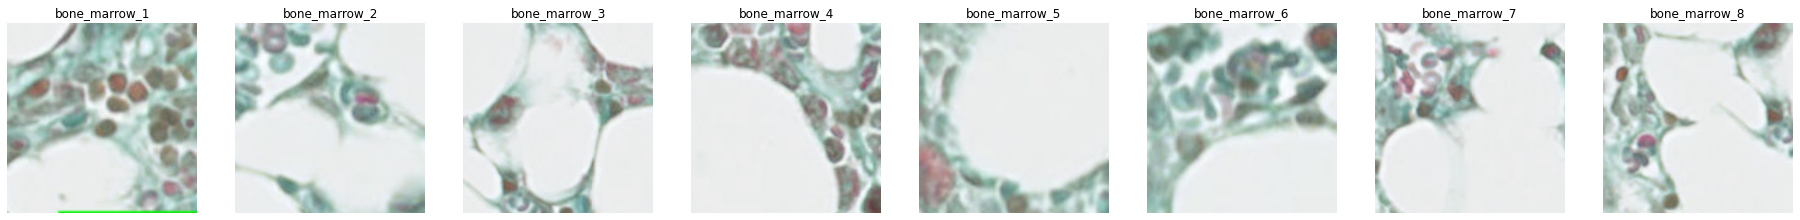

In [ ]:
images = []
names = []

#Get first image of bone_marrow 
test_bone_marrow_filenames = os.listdir(test_bone_marrow_dir)

#Plot the first image
images.append(mpimg.imread(test_bone_marrow_dir + "/" + test_bone_marrow_filenames[0]))
names.append("bone_marrow_1")

#Get second image of bone_marrow
test_bone_marrow_filenames = os.listdir(test_bone_marrow_dir)

#Plot the second image
images.append(mpimg.imread(test_bone_marrow_dir + "/" + test_bone_marrow_filenames[1]))
names.append("bone_marrow_2")

#Get third image of bone_marrow
test_bone_marrow_filenames = os.listdir(test_bone_marrow_dir)

#Plot the third image
images.append(mpimg.imread(test_bone_marrow_dir + "/" + test_bone_marrow_filenames[2]))
names.append("bone_marrow_3")

#Get fourth image of bone_marrow
test_bone_marrow_filenames = os.listdir(test_bone_marrow_dir)

#Plot the 4th image
images.append(mpimg.imread(test_bone_marrow_dir + "/" + test_bone_marrow_filenames[3]))
names.append("bone_marrow_4")


#Get 5th image of bone_marrow
test_bone_marrow_filenames = os.listdir(test_bone_marrow_dir)

#Plot the 5th image
images.append(mpimg.imread(test_bone_marrow_dir + "/" + test_bone_marrow_filenames[4]))
names.append("bone_marrow_5")


#Get 6th image of bone_marrow
test_bone_marrow_filenames = os.listdir(test_bone_marrow_dir)

#Plot the 6th image
images.append(mpimg.imread(test_bone_marrow_dir + "/" + test_bone_marrow_filenames[5]))
names.append("bone_marrow_6")


#Get 7th image of bone_marrow
test_bone_marrow_filenames = os.listdir(test_bone_marrow_dir)

#Plot the 7th image
images.append(mpimg.imread(test_bone_marrow_dir + "/" + test_bone_marrow_filenames[6]))
names.append("bone_marrow_7")


#Get 8th image of bone_marrow
test_bone_marrow_filenames = os.listdir(test_bone_marrow_dir)

#Plot the 8th image
images.append(mpimg.imread(test_bone_marrow_dir + "/" + test_bone_marrow_filenames[7]))
names.append("bone_marrow_8")

#Get 8th image of bone_marrow
test_bone_marrow_filenames = os.listdir(test_bone_marrow_dir)

#Plot the 8th image
images.append(mpimg.imread(test_bone_marrow_dir + "/" + test_bone_marrow_filenames[7]))
names.append("bone_marrow_9")

nrows = 1
ncols = 8
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
for i in range(8):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(images[i])
  plt.title(names[i])
plt.show()

[[0.0000000e+00 1.4271793e-33 1.0000000e+00 1.8152263e-38 4.8545509e-25]]
This image is 0.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 100.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


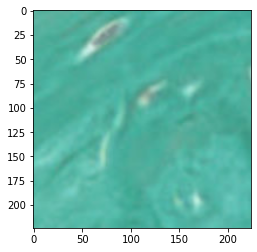

In [ ]:
predict_image("/content/Bone_parts/test/bone_with_osteocytes/1-1 1.tif")

[[0.0000000e+00 2.6304515e-30 1.0000000e+00 1.0420740e-32 1.2772249e-23]]
This image is 0.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 100.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


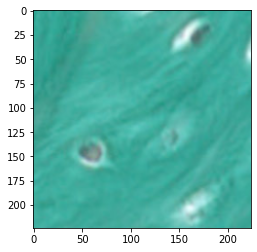

In [ ]:
predict_image("/content/Bone_parts/test/bone_with_osteocytes/9-1 2.tif")

[[2.7287572e-13 2.5168796e-14 6.2363794e-09 1.0000000e+00 7.1080586e-19]]
This image is 0.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 100.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


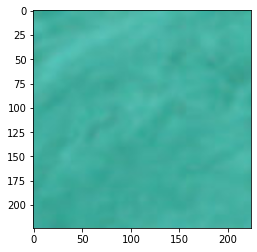

In [ ]:
predict_image("/content/Bone_parts/test/bone_without_osteocytes/1-12 1.tif")

[[1.0183827e-14 8.9588144e-16 5.2316895e-10 1.0000000e+00 1.0356480e-21]]
This image is 0.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 100.00 percent bone_without_osteocytes
 This image is 0.00 percent tissue_fibrous


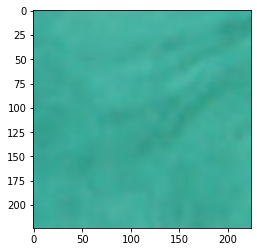

In [ ]:
predict_image("/content/Bone_parts/test/bone_without_osteocytes/2-5 1.tif")

[[3.6745129e-18 1.9227085e-10 4.2556803e-13 3.7495448e-11 1.0000000e+00]]
This image is 0.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 100.00 percent tissue_fibrous


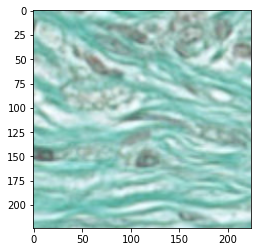

In [ ]:
predict_image("/content/Bone_parts/test/tissue_fibrous/10-1 1.tif")

[[6.1945325e-06 1.5905173e-04 1.3926470e-07 2.8096117e-06 9.9983180e-01]]
This image is 0.00 percent biomaterial
 This image is 0.02 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 99.98 percent tissue_fibrous


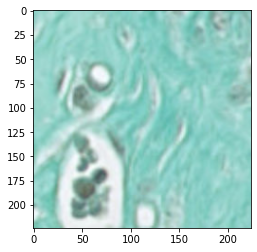

In [ ]:
predict_image("/content/Bone_parts/test/tissue_fibrous/3-5 2.tif")

[[3.26478657e-05 1.34957745e-05 2.16901452e-09 7.07436925e-07
  9.99953151e-01]]
This image is 0.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 100.00 percent tissue_fibrous


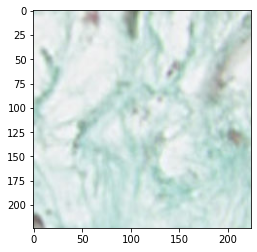

In [ ]:
predict_image("/content/Bone_parts/test/tissue_fibrous/8-8 1.tif")

[[1.2143498e-25 6.8015694e-13 1.5336559e-15 5.2807259e-13 1.0000000e+00]]
This image is 0.00 percent biomaterial
 This image is 0.00 percent bone marrow
 This image is 0.00 percent bone_with_osteocytes
 This image is 0.00 percent bone_without_osteocytes
 This image is 100.00 percent tissue_fibrous


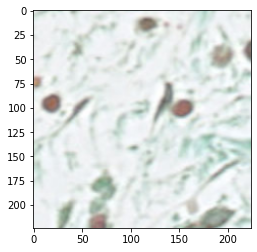

In [ ]:
predict_image("/content/Bone_parts/train/tissue_fibrous/6seven-1 2.tif")

In [ ]:
# Try to make confusion matrix 

pred= model_VGG16.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels=(test_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 4 4 4 1 1 4 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 0 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
{'biomaterial': 0, 'bone_marrow': 1, 'bone_with_osteocytes': 2, 'bone_without_osteocytes': 3, 'tissue_fibrous': 4}
['biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'tissue_fibrous', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'bioma

In [ ]:

predictions = model_VGG16.predict(test_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
print(predictions)
print(predicted_classes )

209/209 [==============================] - 7s 31ms/step
[[9.9999642e-01 1.4434526e-06 2.4245023e-11 3.0772438e-09 2.1878870e-06]
 [9.9999642e-01 1.4394179e-06 2.0064131e-11 2.6679525e-09 2.1581634e-06]
 [9.9999595e-01 1.4920184e-06 2.3246792e-11 3.2582663e-09 2.4470021e-06]
 ...
 [1.1088815e-22 3.0878509e-12 2.1361703e-14 1.1733515e-12 1.0000000e+00]
 [8.7745024e-19 5.7220810e-09 5.8338950e-12 3.7059460e-11 1.0000000e+00]
 [1.5958317e-24 6.0649917e-13 2.8187769e-14 9.6032514e-12 1.0000000e+00]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 4 4 4 1 1 4 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 0 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
# Get ground-truth classes and class-labels
true_classes = test_generator.classes
print(true_classes)
class_labels = list(test_generator.class_indices.keys())  

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
report = classification_report(true_classes, predicted_class_indices, target_names=class_labels)
print(report)  
    

                         precision    recall  f1-score   support

            biomaterial       0.96      0.98      0.97        55
            bone_marrow       1.00      0.56      0.71         9
   bone_with_osteocytes       1.00      1.00      1.00        43
bone_without_osteocytes       1.00      1.00      1.00        55
         tissue_fibrous       0.90      0.96      0.93        47

               accuracy                           0.97       209
              macro avg       0.97      0.90      0.92       209
           weighted avg       0.97      0.97      0.96       209



In [ ]:
#Y_pred = model_VGG16.predict_generator(test_generator)
#y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cf_matrix = confusion_matrix(true_classes, predicted_class_indices)
print(cf_matrix)

Confusion Matrix
[[54  0  0  0  1]
 [ 0  5  0  0  4]
 [ 0  0 43  0  0]
 [ 0  0  0 55  0]
 [ 2  0  0  0 45]]


In [ ]:
#import matplotlib.pyplot as plt
#import numpy as np
#from sklearn.metrics import confusion_matrix


#cm = confusion_matrix(test_generator.classes, y_pred)
# or
#cm = np.array([[1401,    0],[1112, 0]])

#plt.imshow(cm, cmap=plt.cm.Blues)
#plt.xlabel("Predicted labels")
#plt.ylabel("True labels")
#plt.xticks([], [])
#plt.yticks([], [])
#plt.title('Confusion matrix ')
#plt.colorbar()
#plt.show()

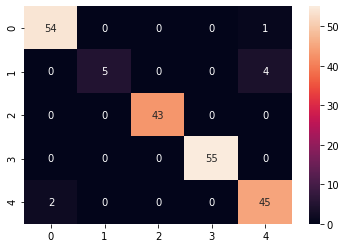

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)



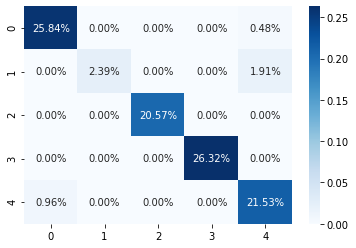

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

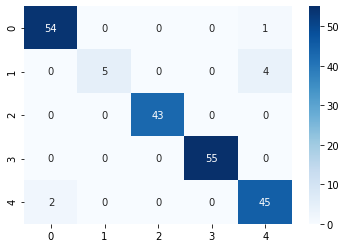

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')

In [ ]:
# reference: stackoverflow 
# https://stackoverflow.com/a/50386871

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

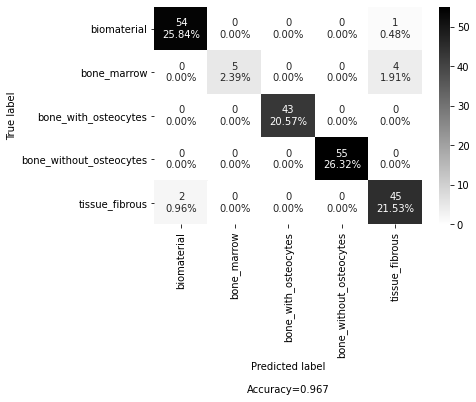

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['biomaterial', 'bone_marrow', 'bone_with_osteocytes', 'bone_without_osteocytes', 'tissue_fibrous']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')
